<img src="Ufo-icon.png" height="256" width="256" style="float: right">

# A Needle in a Data Haystack - Final Project
## Matan Cohen, Nir Schipper & Ran Shaham
### Exploring UFO sightings data (or - ARE ALIENS REAL?)

### Initialization

In [1]:
# imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import html
import ipywidgets as widgets

In [2]:
# constants
FILENAME = 'scrubbed.csv'
DATETIME = 'datetime'
YEAR = 'year'
COUNTRY = 'country'
SHAPE = 'shape'
COUNT = 'count'
DUR_HOURS = 'duration (hours/min)'
DUR_SECONDS = 'duration (seconds)'
DURATION = 'duration'
DESCRIPTION = 'comments'
LAT = 'latitude'
LON = 'longitude'

DATE_FORMAT = '%m/%d/%Y %H:%M'
FIX_TIME_REGEX = (r'\s24:(\d{2})\s*$', r' 00:\1')

In [3]:
# magic & settings
%matplotlib inline
# big, juicy plots
sns.set_context('talk')
LARGE_FIGSIZE = (12, 8)
sns.set_style(style='white', rc={'figsize': LARGE_FIGSIZE})
plt.rcParams.update({
    'figure.figsize': LARGE_FIGSIZE,
})

### Read & Clean the dataset

Read the csv file:

In [4]:
data = pd.read_csv(FILENAME, low_memory=False)

and clean it up:

In [5]:
# make comments readable (unescape html)
data.loc[:, DESCRIPTION] = data[DESCRIPTION].apply(lambda val: html.unescape(str(val)))

# parse datetime - fix 24h format first (24:xx --> 00:xx)
# and insert a year column
data.loc[:, DATETIME] = data[DATETIME].apply(lambda val: re.sub(*FIX_TIME_REGEX, str(val)))
data.loc[:, DATETIME] = pd.to_datetime(data[DATETIME], format=DATE_FORMAT, errors='coerce')
data.insert(1, YEAR, data[DATETIME].dt.year)
data.loc[:, YEAR] = data[YEAR].fillna(0).astype(int)

# tidy up the rest of the textual columns
data.loc[:, 'city'] = data['city'].str.title()
for col in ['state', 'country']:
    data.loc[:, col] = data[col].str.upper()

# parse location data
data[LAT] = pd.to_numeric(data[LAT], errors='coerce')
data = data.rename(columns={'longitude ': LON})

# drop the duration in hours column and rename the one with the seconds
data = data.drop(DUR_HOURS, axis=1)
data = data.rename(columns={DUR_SECONDS: DURATION})

# get a list of all years with sightings
years = np.unique(data[YEAR])

# display the result
data.head()

,datetime,year,city,state,country,shape,duration,comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,1949,San Marcos,TX,US,cylinder,2700,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,1949-10-10 21:00:00,1949,Lackland Afb,TX,NaN,light,7200,"1949 Lackland AFB, TX. Lights racing across t...",12/16/2005,29.384210,-98.581082
2,1955-10-10 17:00:00,1955,Chester (Uk/England),NaN,GB,circle,20,"Green/Orange circular disc over Chester, England",1/21/2008,53.200000,-2.916667
3,1956-10-10 21:00:00,1956,Edna,TX,US,circle,20,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
4,1960-10-10 20:00:00,1960,Kaneohe,HI,US,light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611


### Shapes analysis

First, we extract the unique shape values from all sightings:

In [6]:
shapes = pd.unique(data[SHAPE])
shapes = [shape for shape in shapes if not pd.isnull(shape)]

... and for every year, get the proportion of sightings with a given shape:

In [7]:
# get the distribution of each shape for every year
def get_shape_distribution(shape, data):
    if len(data) > 0:
        return len(data.loc[data[SHAPE] == shape, SHAPE]) / len(data)
    else:
        return 0

shapes_dist = pd.DataFrame(columns=[YEAR, SHAPE, COUNT]).set_index([YEAR, SHAPE])
for year in years:
    year_data = data.loc[data[YEAR] == year, :]
    shapes_distributions = {shape: get_shape_distribution(shape, year_data)
                            for shape in shapes}
    for shape in shapes:
        shapes_dist.loc[(year, shape), COUNT] = shapes_distributions[shape]

Use the following widget to explore the change in shapes in sightings over the years.

_Pro tip: The real action starts at ~1950..._

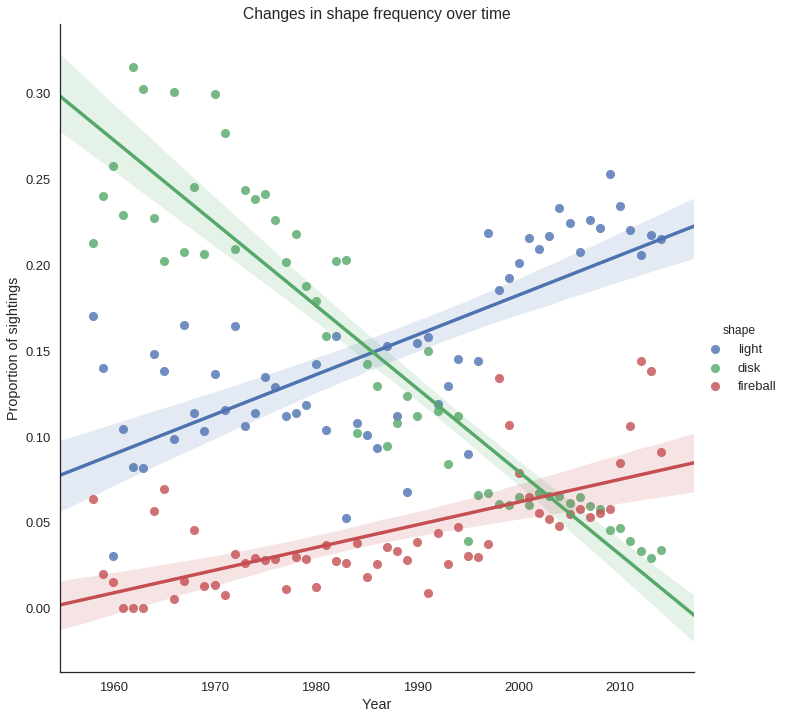

In [12]:
select_years_widget = widgets.widgets.IntRangeSlider(
    min = years[0],
    max = years[-1],
    value = (1960, 2014),
    step = 1,
    description = 'Years range'
)

select_shapes_widget = widgets.widgets.SelectMultiple(
    options = shapes,
    value = ['disk', 'light', 'fireball'],
    description = 'Shapes to plot. Use Ctrl to select multiple values:',
    disabled = False
)

# an interactive plotting function
@widgets.interact_manual(years_range=select_years_widget,
                         selected_shapes=select_shapes_widget)
def plot_shape_distributions(years_range, selected_shapes):
    # get all years in the selected range
    selected_years = years[(years >= years_range[0]) & 
                           (years <= years_range[1])]
    selected_data = shapes_dist.loc[(selected_years, selected_shapes), COUNT].reset_index()
    # plot & format
    sns.lmplot(x=YEAR, y=COUNT, hue=SHAPE, data=selected_data, size=10)
    plt.title('Changes in shape frequency over time')
    plt.xlabel('Year')
    plt.ylabel('Proportion of sightings')

_We get a lot less disk-shaped UFOs these days. What a shame._

### Duration Analysis

In [9]:
SELECTED_COUNTRIES = ['AU', 'GB', 'US', 'CA']
import collections
def calcduration(duration):
    s = 0
    disqualified = 0
    for d in duration:
        try:
            #eliminate outliers
            #if a sighting lasts more than two days
            if(float(d)/3600 < 48):
                s = s+(float(d)/60)
            else:
                disqualified = disqualified+1
        except:
            pass
    return s,disqualified

def averageDurationPerYear():
    averageDurationPerYear = {}
    for year in years:
        num_sightings = len(data.loc[data[YEAR] == year, :])
        duration = data.loc[data[YEAR] == year, DURATION]
        [sumOfDurations,disqualified] = calcduration(duration)
        averageDurationPerYear[year] = sumOfDurations/(num_sightings-disqualified)

    x = []
    y = []
    averageDurationPerYear = collections._OrderedDictItemsView(averageDurationPerYear)
    for key,val in averageDurationPerYear:
        x.append(key)
        y.append(val)
    plt.xlabel('Year')
    plt.ylabel('average time ogf sighting in minutes ')
    plt.title('average time of sighting each year')
    plt.plot(x, y, color="blue")

def averageDurationPerCountry():
    averageDurationPerCountry = {}
    for country in SELECTED_COUNTRIES:
        num_sightings = len(data.loc[data[COUNTRY] == country , :])
        duration = data.loc[data[COUNTRY] == country, DURATION]
        [sumOfDurations,disqualified] = calcduration(duration)
        averageDurationPerCountry[country] = sumOfDurations/(num_sightings - disqualified)
    x = []
    y = []

    for key,val in averageDurationPerCountry.items():
        x.append(key)
        y.append(val)
    plt.figure()
    plt.xlabel('country')
    plt.ylabel('average time ogf sighting in minutes ')
    plt.title('average time of sighting per counrty')
    y_pos = np.arange(len(x))
    plt.bar(y_pos, y, align = 'center',alpha = 0.5)
    plt.xticks(y_pos,x)

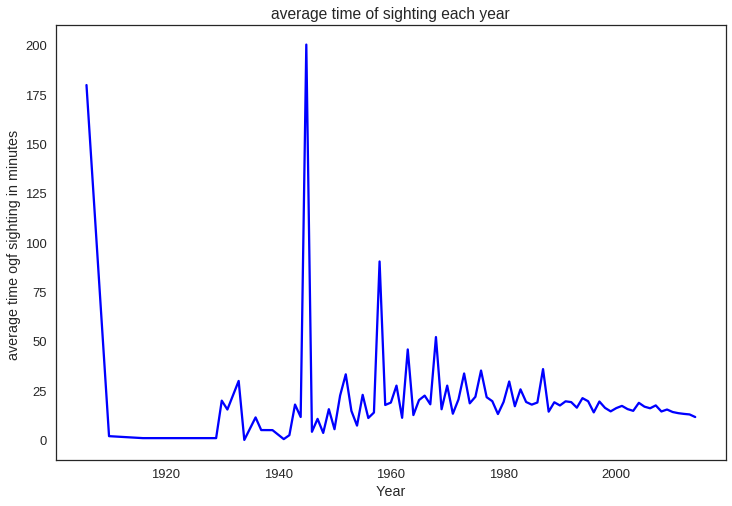

In [10]:
averageDurationPerYear()

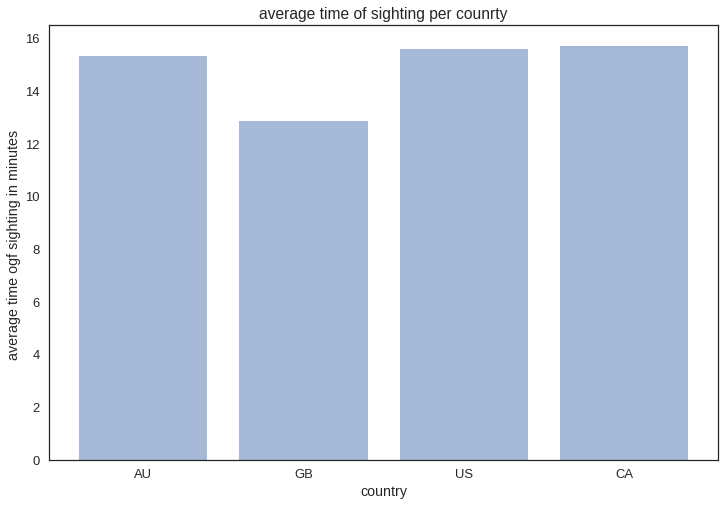

In [11]:
averageDurationPerCountry()

### Locations Analysis